Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Step 1, Loss: 642.894897
Step 1000, Loss: 147.750198
Step 2000, Loss: 125.224426
Step 3000, Loss: 121.727524
Step 4000, Loss: 130.927856
Step 5000, Loss: 118.862305
Step 6000, Loss: 125.179352
Step 7000, Loss: 116.054337
Step 8000, Loss: 121.613007
Step 9000, Loss: 115.993988
Step 10000, Loss: 107.479095
Step 11000, Loss: 121.517433
Step 12000, Loss: 119.690910
Step 13000, Loss: 115.546875
Step 14000, Loss: 112.299370
Step 15000, Loss: 119.548630
Step 16000, Loss: 111.034027
Step 17000, Loss: 114.777237
Step 18000, Loss: 116.644775
Step 19000, Loss: 112.389046
Step 20000, Loss: 113.006088
Step 21000, Loss: 114.997864
Step 22000, Loss: 114.353523
Step 23000, Loss: 110.010979
Step 24000, Loss: 114.890572
Step 25000, Loss: 116.094086
Step 26000, Loss: 113.224823
Step 27000, Loss: 116.700256
Step 28000, Loss: 123.955109
Step 29000, Loss: 116.570908
Step 30000, Loss: 101.822495
3
3
7
7
5
5
1
1
8
8
0
0
3
3
5
5
9
9
2
2


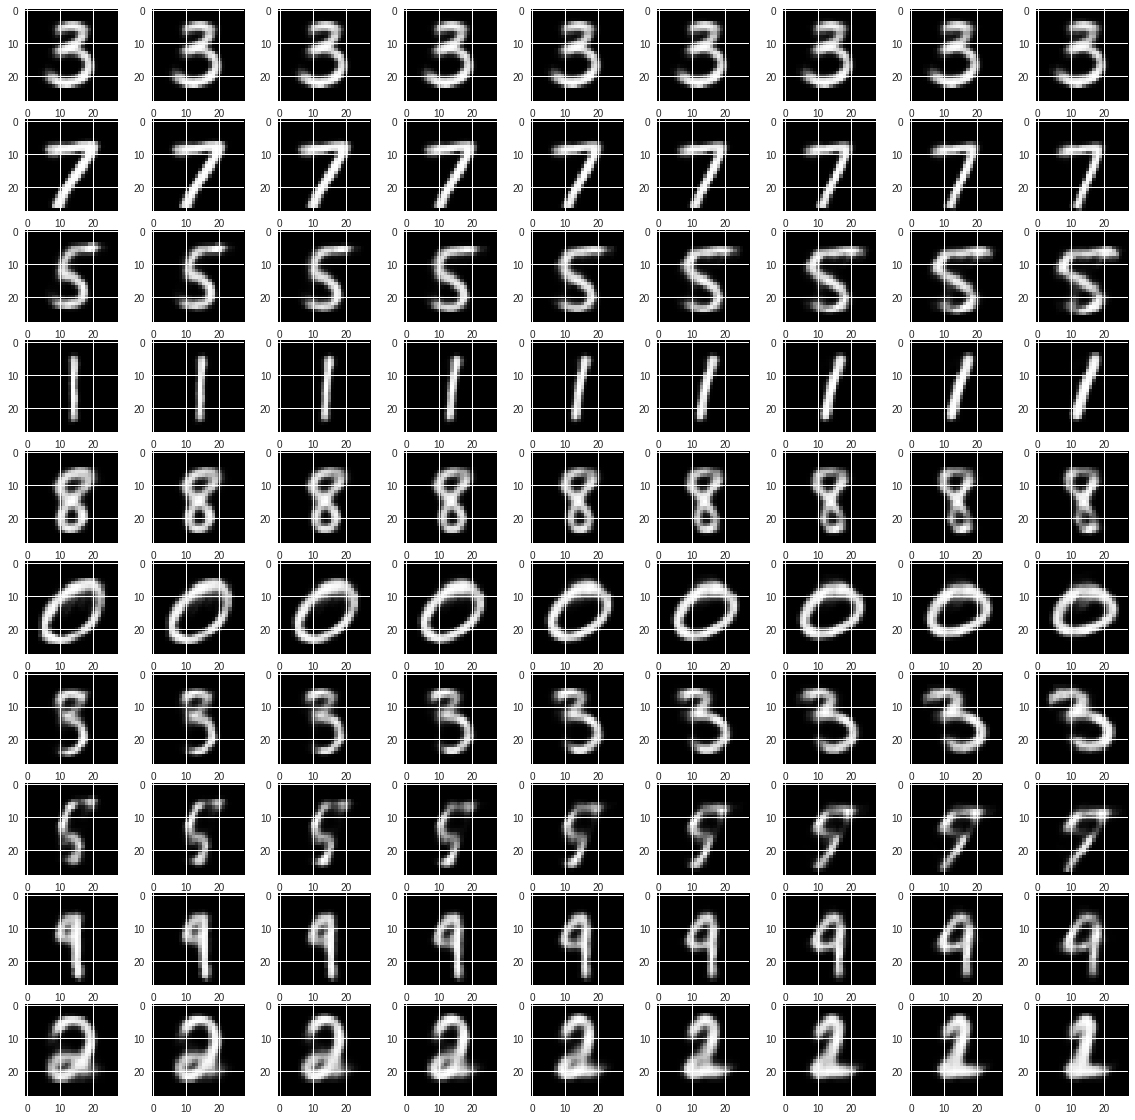

In [0]:
""" Variational Auto-Encoder Example.
Using a variational auto-encoder to generate digits images from noise.
MNIST handwritten digits are used as training examples.
References:
    - Auto-Encoding Variational Bayes The International Conference on Learning
    Representations (ICLR), Banff, 2014. D.P. Kingma, M. Welling
    - Understanding the difficulty of training deep feedforward neural networks.
    X Glorot, Y Bengio. Aistats 9, 249-256
    - Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based
    learning applied to document recognition." Proceedings of the IEEE,
    86(11):2278-2324, November 1998.
Links:
    - [VAE Paper] https://arxiv.org/abs/1312.6114
    - [Xavier Glorot Init](www.cs.cmu.edu/~bhiksha/courses/deeplearning/Fall.../AISTATS2010_Glorot.pdf).
    - [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""
from __future__ import division, print_function, absolute_import

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import random

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
sess = tf.InteractiveSession()
# Parameters
learning_rate = 0.001
num_steps = 30000
batch_size = 64

# Network Parameters
image_dim = 784 # MNIST images are 28x28 pixels
hidden_dim = 512
latent_dim = 7

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

# Variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

# Building the encoder
input_image = tf.placeholder(tf.float32, shape=[None, image_dim])
encoder = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
#print(z_mean.shape)
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# Sampler: Normal (gaussian) random distribution
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

# Building the decoder (with scope to re-use these layers later)
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)


# Define VAE Loss
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)
    
loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
        sess.run(init)

        for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
              batch_x, _ = mnist.train.next_batch(batch_size)

        # Train
              feed_dict = {input_image: batch_x}
              _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
              if i % 1000 == 0 or i == 1:
                  print('Step %i, Loss: %f' % (i, l))
                  
       
      
       #Creating the Dictionary for storing the indexes of labels
        x=mnist.test.images
        y=mnist.test.labels
        
        dic={"0":[],"1":[],"2":[],"3":[],"4":[],"5":[],"6":[],"7":[],"8":[],"9":[]}
        x=mnist.test.images

        y=mnist.test.labels
        for i in range(len(y)):
          if y[i]==0:
              dic["0"].append(i)

          if y[i]==1:
              dic["1"].append(i)

          if y[i]==2:
              dic["2"].append(i)

          if y[i]==3:
              dic["3"].append(i)

          if y[i]==4:
              dic["4"].append(i)

          if y[i]==5:
              dic["5"].append(i)

          if y[i]==6:
              dic["6"].append(i)

          if y[i]==7:
              dic["7"].append(i)

          if y[i]==8:
              dic["8"].append(i)

          if y[i]==9:
              dic["9"].append(i)
              
          
        #print(dic["0"])
              
              
        #Testing
        #Generator takes noise as input
        noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])
        
        # Rebuild the decoder to create image from noise
        decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
        decoder = tf.nn.tanh(decoder)
        decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
        decoder = tf.nn.sigmoid(decoder)

              
         
          
        fig_size = plt.rcParams["figure.figsize"]
 
 
        # Set figure width to 20 and height to 20
        fig_size[0] = 20
        fig_size[1] = 20
        plt.rcParams["figure.figsize"] = fig_size
        
        for h in range(1,91,9):
            
            l=[]
            #Random sample the digit
            ran=random.sample([0,1,2,3,4,5,6,7,8,9],1)
            
            #Now sample the above digits randomly from the dictionary
            
            m=list(dic[str(ran[0])])
            num=random.sample(m,2)
            
            #Append the randomly selected digits to the list
            l.append(x[num[0],:])
            l.append(x[num[1],:])
            print(y[num[0]])
            print(y[num[1]])
            
            #ouput from the encoder of the selected images
            a=sess.run(z,feed_dict={input_image:l})




            #Plot the first digit (output of the decoder)
            f=sess.run(decoder,feed_dict={noise_input: a[0].reshape(-1,7)})
            plt.subplot(10, 9, h)

            plt.imshow(f.reshape(28,28),cmap='gray')


              
            w=h
            #creating the 7 interpolating vectors ,then passing it ot the decoder for output
            
            for s in range(1,8):
                    q=a[0,:]+ ((s/8)*(a[1,:]-a[0,:]))
                    f=sess.run(decoder,feed_dict={noise_input: q.reshape(-1,7)})
                    w=w+1
                    plt.subplot(10, 9,w)

                    plt.imshow(f.reshape(28,28),cmap='gray')


            #Plot the last image
            f=sess.run(decoder,feed_dict={noise_input: a[1].reshape(-1,7)})


            plt.subplot(10, 9,w+1)
            plt.imshow(f.reshape(28,28),cmap='gray')
                  





     

  
    
            
            
    
    

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Step 1, Loss: 654.634155
Step 1000, Loss: 131.031509
Step 2000, Loss: 134.409485
Step 3000, Loss: 136.521301
Step 4000, Loss: 125.366379
Step 5000, Loss: 118.633942
Step 6000, Loss: 119.696396
Step 7000, Loss: 122.648849
Step 8000, Loss: 113.208969
Step 9000, Loss: 119.136253
Step 10000, Loss: 117.287575
Step 11000, Loss: 117.218094
Step 12000, Loss: 116.279716
Step 13000, Loss: 114.789986
Step 14000, Loss: 120.800125
Step 15000, Loss: 120.772095
Step 16000, Loss: 112.979523
Step 17000, Loss: 112.116600
Step 18000, Loss: 118.043076
Step 19000, Loss: 113.243210
Step 20000, Loss: 113.666779
Step 21000, Loss: 112.318352
Step 22000, Loss: 117.957672
Step 23000, Loss: 107.655029
Step 24000, Loss: 112.959908
Step 25000, Loss: 111.531006
Step 26000, Loss: 121.672302
Step 27000, Loss: 113.827713
Step 28000, Loss: 111.627716
Step 29000, Loss: 114.037262
Step 30000, Loss: 108.981018
6
4
0
2
4
1
1
4
3
7
3
1
6
1
5
1
0
3
1
4


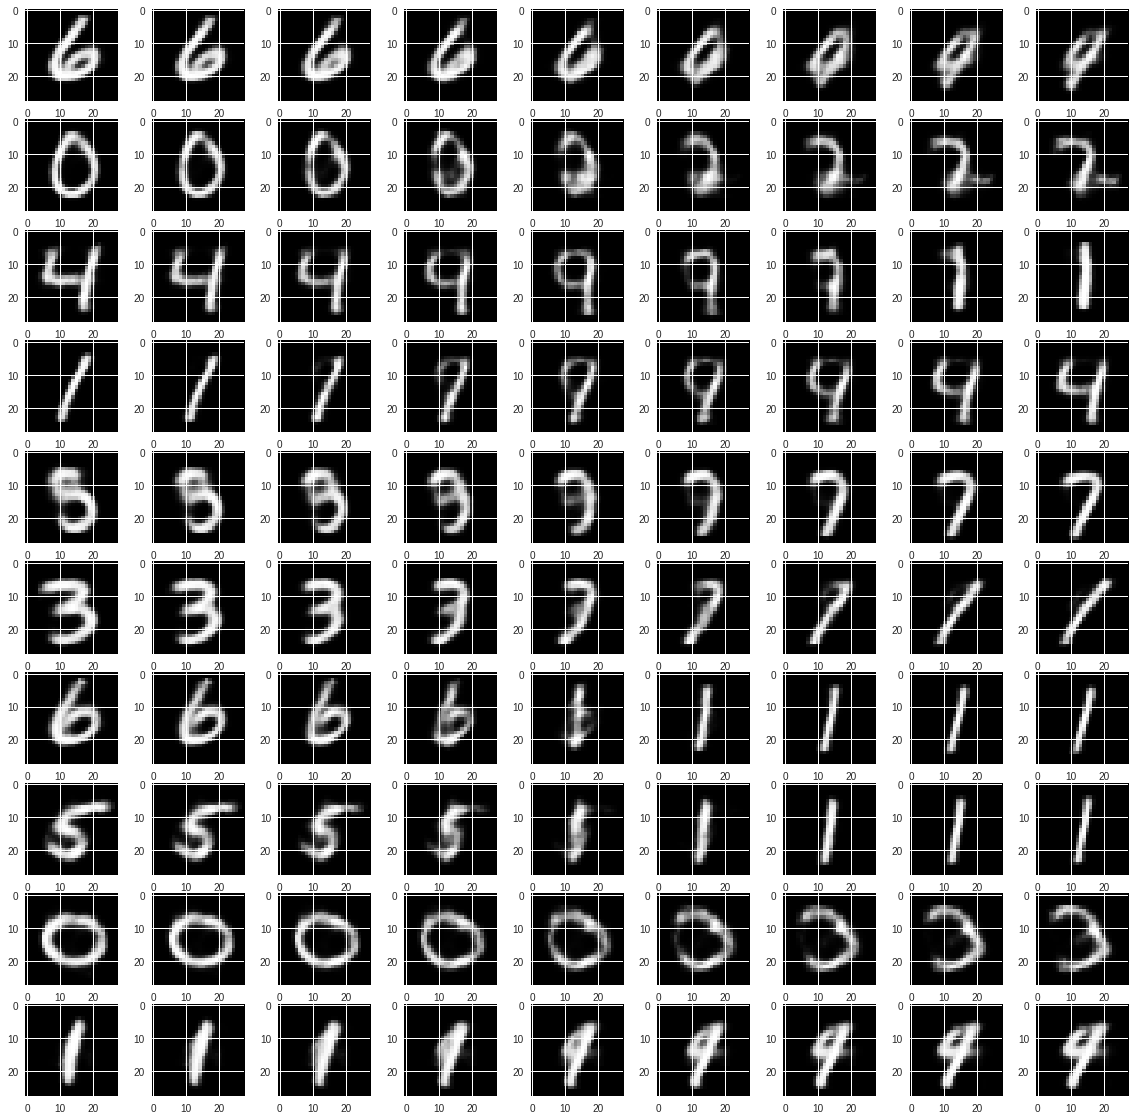

In [0]:
""" Variational Auto-Encoder Example.
Using a variational auto-encoder to generate digits images from noise.
MNIST handwritten digits are used as training examples.
References:
    - Auto-Encoding Variational Bayes The International Conference on Learning
    Representations (ICLR), Banff, 2014. D.P. Kingma, M. Welling
    - Understanding the difficulty of training deep feedforward neural networks.
    X Glorot, Y Bengio. Aistats 9, 249-256
    - Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based
    learning applied to document recognition." Proceedings of the IEEE,
    86(11):2278-2324, November 1998.
Links:
    - [VAE Paper] https://arxiv.org/abs/1312.6114
    - [Xavier Glorot Init](www.cs.cmu.edu/~bhiksha/courses/deeplearning/Fall.../AISTATS2010_Glorot.pdf).
    - [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""
from __future__ import division, print_function, absolute_import

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import random

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
sess = tf.InteractiveSession()
# Parameters
learning_rate = 0.001
num_steps =30000
batch_size = 64

# Network Parameters
image_dim = 784 # MNIST images are 28x28 pixels
hidden_dim = 512
latent_dim = 7

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

# Variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

# Building the encoder
input_image = tf.placeholder(tf.float32, shape=[None, image_dim])
encoder = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
#print(z_mean.shape)
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# Sampler: Normal (gaussian) random distribution
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

# Building the decoder (with scope to re-use these layers later)
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)


# Define VAE Loss
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)
    
loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
        sess.run(init)

        for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
              batch_x, _ = mnist.train.next_batch(batch_size)

        # Train
              feed_dict = {input_image: batch_x}
              _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
              if i % 1000 == 0 or i == 1:
                  print('Step %i, Loss: %f' % (i, l))
                  
        
        x=mnist.test.images
        y=mnist.test.labels
        
        #creating the dictionary for storing the indexes
        
        dic={"0":[],"1":[],"2":[],"3":[],"4":[],"5":[],"6":[],"7":[],"8":[],"9":[]}
        x=mnist.test.images

        y=mnist.test.labels
        for i in range(len(y)):
          if y[i]==0:
              dic["0"].append(i)

          if y[i]==1:
              dic["1"].append(i)

          if y[i]==2:
              dic["2"].append(i)

          if y[i]==3:
              dic["3"].append(i)

          if y[i]==4:
              dic["4"].append(i)

          if y[i]==5:
              dic["5"].append(i)

          if y[i]==6:
              dic["6"].append(i)

          if y[i]==7:
              dic["7"].append(i)

          if y[i]==8:
              dic["8"].append(i)

          if y[i]==9:
              dic["9"].append(i)
              
   
              
              
         #Testing
        #Generator takes noise as input
        noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])
        
        # Rebuild the decoder to create image from noise
        decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
        decoder = tf.nn.tanh(decoder)
        decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
        decoder = tf.nn.sigmoid(decoder)

              
         
          
        fig_size = plt.rcParams["figure.figsize"]
 
 
        # Set figure width to 20 and height to 20
        fig_size[0] = 20
        fig_size[1] = 20
        plt.rcParams["figure.figsize"] = fig_size
        
        for h in range(1,91,9):
            #d=d+1
            #print(d)
            #for k in d:
            
            #Randomly sample the two different digits
            l=[]
            ran=random.sample([0,1,2,3,4,5,6,7,8,9],2)
                  #print("vv",k)
            m=list(dic[str(ran[0])])
            num1=random.sample(m,1)
                  #print(num)
            m=list(dic[str(ran[1])])
            num2=random.sample(m,1)
            print(y[num1[0]])
            print(y[num2[0]])
            #Appending the pixels of the two randomly selected digits
            l.append(x[num1])
            #print(np.array(l).shape)
            l.append(x[num2])
            
            #print(np.array(l).shape)

            #Creating the encoded images
            a=sess.run(z,feed_dict={input_image:(np.array(l).reshape(-1,784))})




            # Plotting the first decoded image
            f=sess.run(decoder,feed_dict={noise_input: a[0].reshape(-1,7)})
            plt.subplot(10, 9, h)

            plt.imshow(f.reshape(28,28),cmap='gray')



            w=h
            #Creating 7 evenly separated interpolates and plotting the decoded image of each
            for s in range(1,8):
                    q=a[0,:]+ ((s/8)*(a[1,:]-a[0,:]))
                    f=sess.run(decoder,feed_dict={noise_input: q.reshape(-1,7)})
                    w=w+1
                    plt.subplot(10, 9,w)

                    plt.imshow(f.reshape(28,28),cmap='gray')


            #Plotting the final decoded image
            f=sess.run(decoder,feed_dict={noise_input: a[1].reshape(-1,7)})


            plt.subplot(10, 9,w+1)
            plt.imshow(f.reshape(28,28),cmap='gray')
                  





     

  
    
            
            
    
    

In [0]:
c=[1,2]
np.array(c).shape

(2,)

In [0]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
dic={"0":[],"1":[],"2":[],"3":[],"4":[],"5":[],"6":[],"7":[],"8":[],"9":[]}
x=mnist.test.images

y=mnist.test.labels
for i in range(len(y)):
  if y[i]==0:
      dic["0"].append(i)
      
  if y[i]==1:
      dic["1"].append(i)
  
  if y[i]==2:
      dic["2"].append(i)
  
  if y[i]==3:
      dic["3"].append(i)
  
  if y[i]==4:
      dic["4"].append(i)
  
  if y[i]==5:
      dic["5"].append(i)
  
  if y[i]==6:
      dic["6"].append(i)
  
  if y[i]==7:
      dic["7"].append(i)
  
  if y[i]==8:
      dic["8"].append(i)
  
  if y[i]==9:
      dic["9"].append(i)
  
    

In [0]:
import random
random.sample(dic[str(0)],2)

[6400, 9519]

In [0]:
type(dic[str(0)])

list

In [0]:
import random

fig, ax = plt.subplots(nrows=10, ncols=9)
for k in range(10):
    l=[]
    num=random.sample(dic["5"],2)
    l.append(num[0])
    l.append(num[1])
    
    
    
    a=sess.run(z,feed_dict={input_image:l})
    
    
    
    
    #Testing
    #Generator takes noise as input
    noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])
    # Rebuild the decoder to create image from noise
    decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
    decoder = tf.nn.tanh(decoder)
    decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
    decoder = tf.nn.sigmoid(decoder)
   
    f=sess.run(decoder,feed_dict={noise_input: a[0].reshape(-1,2)})
    plt.imshow(f.reshape(28,28),cmap='gray')
    
      
    
   
    for s in range(1,8):
      q=a[0,:]+ ((s/8)*(a[1,:]-a[0,:]))
      f=sess.run(decoder,feed_dict={noise_input: q.reshape(-1,2)})
      plt.imshow(f.reshape(28,28),cmap='gray')
     
      
    
    f=sess.run(decoder,feed_dict={noise_input: a[1].reshape(-1,2)})
    plt.imshow(f.reshape(28,28),cmap='gray')
    plt.show()
    
    
    
    

     
    

[3,
 10,
 13,
 25,
 28,
 55,
 69,
 71,
 101,
 126,
 136,
 148,
 157,
 183,
 188,
 192,
 194,
 215,
 246,
 269,
 271,
 294,
 296,
 297,
 305,
 311,
 312,
 324,
 327,
 346,
 365,
 372,
 380,
 407,
 424,
 440,
 441,
 443,
 459,
 485,
 490,
 498,
 525,
 545,
 546,
 552,
 561,
 564,
 567,
 581,
 586,
 592,
 597,
 608,
 611,
 620,
 642,
 644,
 656,
 661,
 701,
 704,
 713,
 717,
 721,
 723,
 742,
 750,
 763,
 794,
 804,
 821,
 845,
 851,
 854,
 871,
 884,
 895,
 896,
 904,
 932,
 972,
 981,
 993,
 997,
 1001,
 1009,
 1034,
 1047,
 1061,
 1084,
 1094,
 1121,
 1148,
 1154,
 1176,
 1188,
 1191,
 1195,
 1197,
 1203,
 1218,
 1220,
 1223,
 1231,
 1246,
 1261,
 1271,
 1273,
 1288,
 1294,
 1297,
 1333,
 1379,
 1390,
 1399,
 1404,
 1408,
 1411,
 1416,
 1438,
 1445,
 1454,
 1457,
 1468,
 1487,
 1504,
 1517,
 1526,
 1533,
 1534,
 1535,
 1558,
 1565,
 1570,
 1589,
 1590,
 1610,
 1619,
 1621,
 1623,
 1638,
 1650,
 1692,
 1700,
 1708,
 1712,
 1713,
 1723,
 1726,
 1739,
 1748,
 1757,
 1762,
 1764,
 1768,
 1

In [0]:
import random
random.sample(dic["2"],2)

ValueError: ignored

In [0]:
v=[]
for s in range(1,8):

   q=a[0,:]+ ((s/8)*(a[1,:]-a[0,:]))
   sess.run(q)
    

In [0]:
import random
random.randrange(3)

0

In [0]:
d

[1]

In [0]:
import random
group_of_items = mnist.test.labels               # a sequence or set will work here.
num_to_select = [0,0]                           # set the number to select here.
list_of_random_items = random.sample(group_of_items, num_to_select)
first_random_item = list_of_random_items[0]
second_random_item = list_of_random_items[1] 

TypeError: ignored

In [0]:
import torch
grid_x = torch.arange(26).repeat(26, 1)
#.view([1, 1, 26, 26])
#.type(FloatTensor)

In [0]:
import random
ran=random.sample([0,1,2,3,4,5,6,7,8,9],1)

In [0]:
ran[0]

2